# **1) Lib Imports**

In [150]:
# Data wrangling

import numpy as np
import pandas as pd

# Visualizations

import seaborn as sns
import matplotlib.pyplot as plt

# K-means

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score

# **2) Data Overview**

In [151]:
df = pd.read_excel("../data/raw/online_retail.xlsx")

In [152]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


Since we expected some errors when trying to read the DB as a csv we will import it as .xlsx.

The issue was being caused by some entries in "Description" column since some values are separated by commas.

In [153]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [154]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Let's give a quick overview for all the variables:

- **InvoiceNo:** A categorical data type. It's a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation. Each invoice number can represent multiple items purchased in a single transaction.
- **Stockcode:** A categorical data type. It's a 5-digit integral number uniquely assigned to each distinct product.
- **Description:** A categorical data type. It contains the name and a brief description of the product.
- **Quantity:** An integer data type. It contains the quantities of each product(item) per transaction.
- **InvoiceDate:** A datetime data type. It indicates the date and time when each transaction was generated.
- **UnitPrice:** A continuous data type. It represents the unit price of each product.
- **CustomerID:** A categorical data type. It's a 5 digit integral number uniquely assigned to each customer.
- **Country:** A categorical data type. It describes the name of the country where each customer resides.

# **3) Data Cleaning and Preprocessing**

## **3.1.) Dealing with Duplicates**

In [155]:
#Check if there are any duplicated rows

df.duplicated().any()

True

In [156]:
#Check how many duplicated rows there are in the df

df.duplicated().sum()

5268

If we think of the dataset we're working with, we can consider that the presence of duplicated rows might be caused by some kind of error when collecting the data.

The reasons that makes me consider it as an error are the following ones:
- Each transaction has a unique ID associated ("InvoiceNo").
- In case it's a cancelled purchase, before the "InvoiceNo" there must appear the letter "c" and then the 6-digit ID.
- If the exact same Client ID is buying the exact same product and quantity twice or more, they must have associated two or more different "InvoiceNo", never the same one.

For this reason, we can delete them safely.

In [157]:
#Let's check some duplicated rows just to be more confident

dupes = df[df.duplicated()]

dupes

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908.0,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2010-12-01 11:45:00,2.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908.0,United Kingdom
555,536412,22327,ROUND SNACK BOXES SET OF 4 SKULLS,1,2010-12-01 11:49:00,2.95,17920.0,United Kingdom
...,...,...,...,...,...,...,...,...
541675,581538,22068,BLACK PIRATE TREASURE CHEST,1,2011-12-09 11:34:00,0.39,14446.0,United Kingdom
541689,581538,23318,BOX OF 6 MINI VINTAGE CRACKERS,1,2011-12-09 11:34:00,2.49,14446.0,United Kingdom
541692,581538,22992,REVOLVER WOODEN RULER,1,2011-12-09 11:34:00,1.95,14446.0,United Kingdom
541699,581538,22694,WICKER STAR,1,2011-12-09 11:34:00,2.10,14446.0,United Kingdom


In [158]:
#Drop duplicated values

df = df.drop_duplicates()

df.shape

(536641, 8)

**EXTRA**

In case we want to go an step further, we could try to find some patterns or relationship with duplicated entries, that could maybe give us an insight or valuable information about what is causing this error.

From a very simple way, we can group by different categories and check if something attracts our attention, detecting a specific field that could cause the values to be duplicated.

In [159]:
#We define a function to check if there are specific values that might cause those duplicated entries

def dupes_summary (df: pd.DataFrame, column: str, df2: pd.DataFrame) -> str:
    total_values = df[column].nunique()
    dupes_values = df2[column].nunique()
    print(f"Out of {total_values} different values for {column} column, there are {dupes_values} duplicated ones.")

In [160]:
dupes_summary(df, "InvoiceNo", dupes)

Out of 25900 different values for InvoiceNo column, there are 1933 duplicated ones.


In [161]:
dupes_summary(df, "StockCode", dupes)

Out of 4070 different values for StockCode column, there are 1706 duplicated ones.


In [162]:
dupes_summary(df, "Description", dupes)

Out of 4223 different values for Description column, there are 1732 duplicated ones.


In [163]:
dupes_summary(df, "CustomerID", dupes)

Out of 4372 different values for CustomerID column, there are 960 duplicated ones.


In [164]:
dupes_summary(df, "Country", dupes)

Out of 38 different values for Country column, there are 14 duplicated ones.


Not enough evidence so far, to determinate what could be causing the duplicated entries.

## **3.2.) Dealing with Nulls**

We could appreciate we have some null values in the columns "Description" (1454) and CustomerID (135080).
Let's see them more clearly in order to find the most suitable way to treat and deal with them.

In [165]:
#Check the rows with null values

nulls = df.isnull().any(axis=1)

df[nulls]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32:00,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32:00,1.66,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
541536,581498,85099B,JUMBO BAG RED RETROSPOT,5,2011-12-09 10:26:00,4.13,NaN,United Kingdom
541537,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,2011-12-09 10:26:00,4.13,NaN,United Kingdom
541538,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,2011-12-09 10:26:00,4.96,NaN,United Kingdom
541539,581498,85174,S/4 CACTI CANDLES,1,2011-12-09 10:26:00,10.79,NaN,United Kingdom


In [166]:
# Calculating the percentage of missing values for each column

missing_data = df.isnull().sum()

missing_percentage = (missing_data[missing_data > 0] / df.shape[0]) * 100

missing_percentage

Description     0.270945
CustomerID     25.163377
dtype: float64

Unfortunately for our analysis, the column "CustomerID" is essential for clustering customers and afterwards create a recommendation system. As we could see in the code above, 25% out of the total customers is undefined.

The best option in that case will be to remove those rows with missing "CustomerId" to maintain the integrity of the cluster and the analysis.

In [167]:
nulls_in_description = df["Description"].isnull()

nulls_in_description_and_customer = df["Description"].isnull() & df["CustomerID"].isnull()

comparison_result = (nulls_in_description == nulls_in_description_and_customer).all()

comparison_result

True

As we could see in the code above all the null values in the "Description" values match with null values in the "CustomerId" column. This means that once we drop rows where there are null values in "CustomerID" we will also drop all the rows where there are null values in "Description".

In [168]:
# We proceed to drop nulls in "CustomerID"

df = df.dropna(subset = ["CustomerID"])

# We check if there are still null values in our dataframe

df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

**EXTRA**

If this was not the case, a good approach for those null values in "Description" might be replacing them with its matching description from other df entries with the exact same product id. Even though, we might consider and take couple of things into account:

1) As the function for duplicated values showed, there are more description values (4223) than product id's (4070). However these two values should match, which indicates us that some descriptions are not well written. We already noticed that when trying to import the df as a .csv, when we were getting an error for having commas there.
2) There's a possibility that those missing descriptions are exclusively for some specific id's, so we won't have the chance to replace them by looking at the value for the same id in other rows. In that case we couldn't fill those null values.

## **3.3.) Matching Description & Stock Code**

As we already mentioned before, there are some entries including commas in their description. This makes us suspect about possible errors in the description values referring to the same "StockCode".

Let's take a look of some rows containing commas, and see how we can handle them.

In [169]:
df[df["Description"].str.contains(",")]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
109,536381,82567,"AIRLINE LOUNGE,METAL SIGN",2,2010-12-01 09:41:00,2.10,15311.0,United Kingdom
253,536394,21506,"FANCY FONT BIRTHDAY CARD,",24,2010-12-01 10:39:00,0.42,13408.0,United Kingdom
956,536520,22760,"TRAY, BREAKFAST IN BED",1,2010-12-01 12:43:00,12.75,14729.0,United Kingdom
1014,536520,21111,"SWISS ROLL TOWEL, CHOCOLATE SPOTS",1,2010-12-01 12:43:00,2.95,14729.0,United Kingdom
1083,536524,21111,"SWISS ROLL TOWEL, CHOCOLATE SPOTS",6,2010-12-01 12:51:00,2.95,17572.0,United Kingdom
...,...,...,...,...,...,...,...,...
541201,581494,21506,"FANCY FONT BIRTHDAY CARD,",12,2011-12-09 10:13:00,0.42,12518.0,Germany
541255,581496,21462,"NURSERY A,B,C PAINTED LETTERS",8,2011-12-09 10:20:00,1.95,16558.0,United Kingdom
541549,581501,22165,"DIAMANTE HEART SHAPED WALL MIRROR,",12,2011-12-09 10:46:00,3.95,12985.0,United Kingdom
541614,581516,21111,"SWISS ROLL TOWEL, CHOCOLATE SPOTS",24,2011-12-09 11:26:00,1.25,14422.0,United Kingdom


We see that not all commas could be replaced by the same character since some might need a blank space, and others just to be deleted.

Let's identify which "StockCode" values have more than one different value in their description.

In [170]:
# Let's group by "StockCode" and count unique values in "Description"

description_ids = df.groupby("StockCode")["Description"].nunique()

# Show stock codes with more than one unique value in "Description"

stock_codes_multiple_descriptions = description_ids[description_ids > 1].index

stock_codes_multiple_descriptions

Index([   20622,    20725,    20914,    21109,    21112,    21175,    21232,
          21243,    21507,    21811,
       ...
       '84997A', '84997B', '84997C', '84997D', '85123A', '85184C', '85185B',
       '90014A', '90014B', '90014C'],
      dtype='object', name='StockCode', length=213)

There are 213 different "StockCode" values that have at least 2 different descriptions. Let's take a look to some of them and see if this is caused by a spell error or something similar, so we can replace them by the first matching value in description.

In [171]:
df_multiple_descriptions = df[df["StockCode"].isin(stock_codes_multiple_descriptions)]

df_multiple_descriptions

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
40,536370,22900,SET 2 TEA TOWELS I LOVE LONDON,24,2010-12-01 08:45:00,2.95,12583.0,France
47,536372,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 09:01:00,1.85,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541884,581585,84946,ANTIQUE SILVER T-LIGHT GLASS,12,2011-12-09 12:31:00,1.25,15804.0,United Kingdom
541888,581585,23145,ZINC T-LIGHT HOLDER STAR LARGE,12,2011-12-09 12:31:00,0.95,15804.0,United Kingdom
541889,581585,22466,FAIRY TALE COTTAGE NIGHT LIGHT,12,2011-12-09 12:31:00,1.95,15804.0,United Kingdom
541903,581587,23256,CHILDRENS CUTLERY SPACEBOY,4,2011-12-09 12:50:00,4.15,12680.0,France


In [172]:
df_multiple_descriptions.sort_values(by = "Description")

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
499204,578653,23437,50'S CHRISTMAS GIFT BAG LARGE,12,2011-11-24 16:40:00,1.25,18161.0,United Kingdom
438520,574326,23437,50'S CHRISTMAS GIFT BAG LARGE,12,2011-11-04 08:29:00,1.25,14913.0,United Kingdom
390220,570501,23437,50'S CHRISTMAS GIFT BAG LARGE,12,2011-10-11 09:23:00,1.25,14857.0,United Kingdom
438194,574308,23437,50'S CHRISTMAS GIFT BAG LARGE,20,2011-11-03 16:45:00,1.25,16409.0,United Kingdom
356143,568044,23437,50'S CHRISTMAS GIFT BAG LARGE,12,2011-09-23 12:10:00,1.25,15763.0,United Kingdom
...,...,...,...,...,...,...,...,...
382637,569920,23145,ZINC T-LIGHT HOLDER STAR LARGE,12,2011-10-06 17:28:00,0.95,13348.0,United Kingdom
313375,C564488,23145,ZINC T-LIGHT HOLDER STAR LARGE,-10,2011-08-25 14:12:00,0.95,16859.0,United Kingdom
346515,567186,23145,ZINC T-LIGHT HOLDER STAR LARGE,12,2011-09-18 16:04:00,0.95,17073.0,United Kingdom
201485,554286,23145,ZINC T-LIGHT HOLDER STARS LARGE,12,2011-05-23 14:16:00,0.95,17686.0,United Kingdom


As we were thinking, each "StockCode" value must have one unique value for the "Description" column.

Let's proceed to replace all these descriptions by the first one associated to each value. This will help us in a future if we want to do visualizations, counts or group by "Description" in order to take some insights about some specific products.

In [173]:
# We determine the first appearing value for each "StockCode", in order to replace it later

first_appearing_description = df.groupby("StockCode")["Description"].first()

# We replace "Description" values for the first appearting value stored in the previous variable

for stockcode in stock_codes_multiple_descriptions:
    first_description = first_appearing_description.loc[stockcode]
    df.loc[df["StockCode"] == stockcode, "Description"] = first_description

In [174]:
unique_stockcodes = df["StockCode"].nunique()

unique_descriptions = df["Description"].nunique()

print(f"The number of unique StockCodes is {unique_stockcodes}, and the number of unique descriptions is {unique_descriptions}.")

The number of unique StockCodes is 3684, and the number of unique descriptions is 3666.


As we could see in the code above, after replacing those descriptions in id's where there were more than one entry, we find that now we have more id's than descriptions. Let's find out what might be causing this:

In [175]:
# Let's group by "Description" and count unique values in "StockCode"

ids_descriptions = df.groupby("Description")["StockCode"].nunique()

# Show stock codes with more than one unique value in "Description"

descriptions_multiple_ids = ids_descriptions[ids_descriptions > 1].index

descriptions_multiple_ids

Index(['COLOURING PENCILS BROWN TUBE', 'COLUMBIAN CANDLE RECTANGLE',
       'COLUMBIAN CANDLE ROUND', 'EAU DE NILE JEWELLED PHOTOFRAME',
       'FRENCH FLORAL CUSHION COVER ', 'FRENCH LATTICE CUSHION COVER ',
       'FROSTED WHITE BASE ', 'METAL SIGN,CUPCAKE SINGLE HOOK',
       'PINK FAIRY CAKE CUSHION COVER', 'PINK FLOCK GLASS CANDLEHOLDER',
       'PINK FLOWERS RABBIT EASTER', 'RETRO PLASTIC 70'S TRAY',
       'RETRO PLASTIC DAISY TRAY', 'RETRO PLASTIC POLKA TRAY',
       'ROUND BLUE CLOCK WITH SUCKER', 'SQUARE CHERRY BLOSSOM CABINET',
       'WHITE BAMBOO RIBS LAMPSHADE'],
      dtype='object', name='Description')

In [176]:
df_multiple_ids = df[df["Description"].isin(descriptions_multiple_ids)]

df_multiple_ids

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
741,536446,10133,COLOURING PENCILS BROWN TUBE,5,2010-12-01 12:15:00,0.85,15983.0,United Kingdom
3093,536597,40001,WHITE BAMBOO RIBS LAMPSHADE,4,2010-12-01 17:35:00,0.85,18011.0,United Kingdom
3330,536621,10135,COLOURING PENCILS BROWN TUBE,10,2010-12-02 10:35:00,1.25,13108.0,United Kingdom
3951,536741,72133,COLUMBIAN CANDLE RECTANGLE,6,2010-12-02 13:11:00,1.25,13117.0,United Kingdom
7070,536987,72130,COLUMBIAN CANDLE ROUND,1,2010-12-03 14:54:00,0.65,17198.0,United Kingdom
...,...,...,...,...,...,...,...,...
541182,581493,79190B,RETRO PLASTIC POLKA TRAY,15,2011-12-09 10:10:00,0.42,12423.0,Belgium
541183,581493,79190A,RETRO PLASTIC 70'S TRAY,15,2011-12-09 10:10:00,0.42,12423.0,Belgium
541189,581493,79191B,RETRO PLASTIC POLKA TRAY,12,2011-12-09 10:10:00,0.85,12423.0,Belgium
541686,581538,79191D,RETRO PLASTIC DAISY TRAY,1,2011-12-09 11:34:00,0.85,14446.0,United Kingdom


In [177]:
df_multiple_ids.sort_values(by = "Description")

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
741,536446,10133,COLOURING PENCILS BROWN TUBE,5,2010-12-01 12:15:00,0.85,15983.0,United Kingdom
142572,548614,10135,COLOURING PENCILS BROWN TUBE,4,2011-04-01 11:47:00,1.25,14419.0,United Kingdom
142242,548561,10135,COLOURING PENCILS BROWN TUBE,10,2011-04-01 10:11:00,1.25,16609.0,United Kingdom
304808,563613,10133,COLOURING PENCILS BROWN TUBE,20,2011-08-18 08:49:00,0.42,12688.0,Israel
305296,563674,10133,COLOURING PENCILS BROWN TUBE,40,2011-08-18 11:59:00,0.42,14132.0,United Kingdom
...,...,...,...,...,...,...,...,...
149396,549293,40003,WHITE BAMBOO RIBS LAMPSHADE,1,2011-04-07 19:16:00,1.25,17883.0,United Kingdom
245061,558570,40001,WHITE BAMBOO RIBS LAMPSHADE,24,2011-06-30 14:38:00,0.85,17673.0,United Kingdom
243325,C558444,40001,WHITE BAMBOO RIBS LAMPSHADE,-2,2011-06-29 13:29:00,0.64,15311.0,United Kingdom
424696,573280,40001,WHITE BAMBOO RIBS LAMPSHADE,12,2011-10-28 13:42:00,0.85,14221.0,United Kingdom


After taking a look to the entries that have different ID for the same product, we decide that it's better to leave it like this since altering the id might cause some issues, and we've been able to reduce the number of not matching pairs from 213 to 18.

## **3.4.) Cancelled Transactions**

As we commented previously, the rows where the "InVoiceNo" starts with a "C" indicates that the transaction was cancelled.

We will create a new column which will indicate it clearer, and it will give more valuable insights to our predictive model.

In [178]:
df["Completion_status"] = df["InvoiceNo"].astype(str).apply(lambda x: not x.startswith("C"))

df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Completion_status
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,True
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,True
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,True
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,True
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,True
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,True
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,True
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,True
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,True


With this new column created, we could later calculate the cancellation ratio for each customer for our new dataframe.

Now we will focus on analyzing a a bit deeper the nature of these data.

In [179]:
df[df["Completion_status"] == False].describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,8872.000000,8872,8872.000000,8872.000000
mean,-30.774910,2011-06-27 09:06:05.024797184,18.899512,14990.152953
min,-80995.000000,2010-12-01 09:41:00,0.010000,12346.000000
25%,-6.000000,2011-03-23 11:23:45,1.450000,13505.000000
50%,-2.000000,2011-07-11 13:51:00,2.950000,14868.000000
75%,-1.000000,2011-10-06 20:36:00,4.950000,16393.000000
max,-1.000000,2011-12-09 11:58:00,38970.000000,18282.000000
std,1172.249902,NaN,445.190864,1708.230387


For what we're trying to understand from this values, "InvoiceDate" and "CustomerID" are not giving us any kind of valuable information, so we will just ignore them.

- We could see the total number of cancelled transactions was 8872 from the total 401604 stored.
- All the quantities, from the min value to the max value, are negative values, indicating that this data was well recorded and stored in the df.
- There's a pretty high spread as we see in the unit price column, being the lowest value in price less than 1 and the highest 38970.

## **3.5.) Understanding Stock Codes**

As we've seen previously, most codes are composed of 5 digits, but some of them include and extra character or even have no numbers at all in their ID.

It might be intereseting to take a closer look to those "StockCode" values that differ from what is expected to be a regular ID for a product.

In [180]:
df["StockCode"].nunique()

3684

In [181]:
#We're going to count how many values are composed by how many numbers out of the 3684 values

unique_stockcodes = pd.Series(df["StockCode"].unique())

unique_stockcodes.apply(lambda x: sum(code.isdigit() for code in str(x))).value_counts()

5    3676
0       7
1       1
Name: count, dtype: int64

Let's take a closer look to those stockcodes that are not composed by 5 digits, and see which kind of products they are.

In [182]:
non_numerical_stockcodes = unique_stockcodes[unique_stockcodes.apply(lambda x: sum(code.isdigit() for code in str(x)) in [0, 1])]

non_numerical_stockcodes

45              POST
111                D
773               C2
859                M
1217    BANK CHARGES
2933            PADS
3409             DOT
3410            CRUK
dtype: object

In [183]:
(df["StockCode"].isin(non_numerical_stockcodes).sum() / len(df)) * 100

0.4768378801007958

We could see that out of the total entries, only a 0.48% are related to these codes. By the name of that codes, we could understand that concepts like "Bank Charges" might not be an actual transaction or purchase by customers.

So the better approach in this case might be to delete those rows where we have those "StockCode" values.

In [184]:
non_numerical_stockcodes = non_numerical_stockcodes.tolist()

df = df[~df["StockCode"].isin(non_numerical_stockcodes)]

In [185]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Completion_status
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,True
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,True
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,True
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,True
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,True
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,True
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,True
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,True
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,True


## **3.6.) Dealing with 0 unit prices**

First of all we need to understand the nature of those rows which could have 0 as their value in unit price. The two main possibilities that come to my mind are the following ones:

- It's a free product because of a promotion, discount code or any similar reason.
- It's an error and its price shouldn't be 0.

Let's take a closer look to those entries.

In [186]:
df[df["UnitPrice"] == 0].describe()[["Quantity"]]

,Quantity
count,33.000000
mean,420.515152
min,1.000000
25%,2.000000
50%,11.000000
75%,36.000000
max,12540.000000
std,2176.713608


As we were mentioning, including these transactions for our model, could potentially cause some deviations and giving inappropriate information of the customers purchase behaviour. So the best approach will be deleting those rows. 

- There are only 33 transactions in total involving products with 0 unit prices.
- Some of these transactions differ from 1 unit of product to 12540.

In [187]:
# We delete rows where unit price is equal to 0

df = df[df["UnitPrice"] != 0]

df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Completion_status
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,True
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,True
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,True
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,True
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,True
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,True
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,True
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,True
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,True


In [188]:
# We reset the index for our dataframe since we're done with the cleaning

df = df.reset_index(drop=True)

# **4) Feature Engineering**

Now that we're done with the understanding and cleaning all the data, we need to create a new dataframe which captures the behavior and characteristics of each customer.

For this process we're going to focus on feature engineering, to get valuable information about the customers.

## **4.1.) Aggregate customer data**

For the new dataframe, we will aggregate transactional data to create meaningful customer-level features. The features we're going to use are the following ones:

- Recency: Time since the last purchase.
- Frequency: Number of purchases.
- Monetary: Total spending.
- Average Order Value: Average spending per order.
- Products Purchased: Count of unique products purchased.

In [189]:
# Let's check if "InvoiceDate" is already datetime data type

df["InvoiceDate"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 399656 entries, 0 to 399655
Series name: InvoiceDate
Non-Null Count   Dtype         
--------------   -----         
399656 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 3.0 MB


**RECENCY**

In [190]:
# We will focus on days since last purchase, so we can substract the hour of purchase and use only the date

df["InvoiceDay"] = df["InvoiceDate"].dt.date

df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Completion_status,InvoiceDay
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,True,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,True,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,True,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,True,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,True,2010-12-01
...,...,...,...,...,...,...,...,...,...,...
399651,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,True,2011-12-09
399652,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,True,2011-12-09
399653,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,True,2011-12-09
399654,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,True,2011-12-09


In [191]:
# For the new dataframe, we will only take the most recent purchase date for each customer

customer_features = df.groupby("CustomerID")["InvoiceDay"].max().reset_index()

customer_features

,CustomerID,InvoiceDay
0,12346.0,2011-01-18
1,12347.0,2011-12-07
2,12348.0,2011-09-25
3,12349.0,2011-11-21
4,12350.0,2011-02-02
...,...,...
4357,18280.0,2011-03-07
4358,18281.0,2011-06-12
4359,18282.0,2011-12-02
4360,18283.0,2011-12-06


In [192]:
# We look for the most recent date in the whole dataframe, so we can make a substraction for each date for each customer

most_recent_date = df["InvoiceDay"].max()

# We make sure both column are in datetime format

customer_features["InvoiceDay"] = pd.to_datetime(customer_features["InvoiceDay"])

most_recent_date = pd.to_datetime(most_recent_date)

# Now we can calculate how many days have passed since the last purchase, and add it in a new column

customer_features["Recency"] = (most_recent_date - customer_features["InvoiceDay"]).dt.days

customer_features.drop(columns = ["InvoiceDay"], inplace=True)

customer_features

,CustomerID,Recency
0,12346.0,325
1,12347.0,2
2,12348.0,75
3,12349.0,18
4,12350.0,310
...,...,...
4357,18280.0,277
4358,18281.0,180
4359,18282.0,7
4360,18283.0,3


**FREQUENCY**

In [193]:
# For the frequency we're going to calculate how many purchases were made by each customer

total_transactions = df.groupby("CustomerID")["InvoiceNo"].nunique().reset_index()

# Once stored in a variable, we can merge it to our new dataframe

customer_features = pd.merge(customer_features, total_transactions, on = "CustomerID")

customer_features

,CustomerID,Recency,InvoiceNo
0,12346.0,325,2
1,12347.0,2,7
2,12348.0,75,4
3,12349.0,18,1
4,12350.0,310,1
...,...,...,...
4357,18280.0,277,1
4358,18281.0,180,1
4359,18282.0,7,3
4360,18283.0,3,16


In [194]:
# We will rename this column for better understanding

customer_features = customer_features.rename(columns = {"InvoiceNo" : "Frequency"})

customer_features

,CustomerID,Recency,Frequency
0,12346.0,325,2
1,12347.0,2,7
2,12348.0,75,4
3,12349.0,18,1
4,12350.0,310,1
...,...,...,...
4357,18280.0,277,1
4358,18281.0,180,1
4359,18282.0,7,3
4360,18283.0,3,16


**MONETARY**

In [195]:
# First we need to calculate the total spend by each customer in each transaction in each product

df["Total_spent"] = df["UnitPrice"] * df["Quantity"]

# Now we can store in a variable to sum it all together by customer ID and later merge it to our new dataframe

total_spent = df.groupby("CustomerID")["Total_spent"].sum().reset_index()

# Merge it to the dataframe

customer_features = pd.merge(customer_features, total_spent, on = "CustomerID")

# Rename

customer_features = customer_features.rename(columns = {"Total_spent" : "Monetary"})

customer_features

,CustomerID,Recency,Frequency,Monetary
0,12346.0,325,2,0.00
1,12347.0,2,7,4310.00
2,12348.0,75,4,1437.24
3,12349.0,18,1,1457.55
4,12350.0,310,1,294.40
...,...,...,...,...
4357,18280.0,277,1,180.60
4358,18281.0,180,1,80.82
4359,18282.0,7,3,176.60
4360,18283.0,3,16,2039.58


**AVERAGE ORDER VALUE**

In [196]:
avg_order_value = total_spent.merge(total_transactions, on = "CustomerID")

avg_order_value["Average_order_value"] = avg_order_value["Total_spent"] / avg_order_value["InvoiceNo"]

customer_features = pd.merge(customer_features, avg_order_value[["CustomerID", "Average_order_value"]], on = "CustomerID")

customer_features

,CustomerID,Recency,Frequency,Monetary,Average_order_value
0,12346.0,325,2,0.00,0.000000
1,12347.0,2,7,4310.00,615.714286
2,12348.0,75,4,1437.24,359.310000
3,12349.0,18,1,1457.55,1457.550000
4,12350.0,310,1,294.40,294.400000
...,...,...,...,...,...
4357,18280.0,277,1,180.60,180.600000
4358,18281.0,180,1,80.82,80.820000
4359,18282.0,7,3,176.60,58.866667
4360,18283.0,3,16,2039.58,127.473750


**PRODUCTS PURCHASED**

In [197]:
# We store the total products bought for each customer

total_products = df.groupby("CustomerID")["Quantity"].sum().reset_index()

# Once stored in a variable, we can merge it to our new dataframe

customer_features = pd.merge(customer_features, total_products, on = "CustomerID")

# Rename the column for better understanding

customer_features = customer_features.rename(columns = {"Quantity" : "Products_purchased"})

customer_features

,CustomerID,Recency,Frequency,Monetary,Average_order_value,Products_purchased
0,12346.0,325,2,0.00,0.000000,0
1,12347.0,2,7,4310.00,615.714286,2458
2,12348.0,75,4,1437.24,359.310000,2332
3,12349.0,18,1,1457.55,1457.550000,630
4,12350.0,310,1,294.40,294.400000,196
...,...,...,...,...,...,...
4357,18280.0,277,1,180.60,180.600000,45
4358,18281.0,180,1,80.82,80.820000,54
4359,18282.0,7,3,176.60,58.866667,98
4360,18283.0,3,16,2039.58,127.473750,1355


## **4.2.) Feature Engineering**

For this step, we will create new features that can help in distinguishing different customer segments.

The new features we're going to add are the following ones:

- Cancelled transactions frequency
- Total unique products purchased
- Favorite day of the week
- Favorite hour of the day

**CANCELLED TRANSACTIONS FREQUENCY**

In [198]:
# we store all the cancelled transaction in a variable

cancelled_transactions = df[df["Completion_status"] == False]

# We store how many cancelled transactions was made by each customer ID

cancellation_frequency = cancelled_transactions.groupby("CustomerID")["InvoiceNo"].nunique().reset_index()

# Merge into the dataframe

customer_features = pd.merge(customer_features, cancellation_frequency, on = "CustomerID", how='left')

# As we will get some null values for this column since not all customer ids had cancelled purchases, we will need to replace those by 0

customer_features["InvoiceNo"].fillna(0, inplace=True)

# Rename the column

customer_features = customer_features.rename(columns = {"InvoiceNo" : "Cancellation_frequency"})

customer_features

,CustomerID,Recency,Frequency,Monetary,Average_order_value,Products_purchased,Cancellation_frequency
0,12346.0,325,2,0.00,0.000000,0,1.0
1,12347.0,2,7,4310.00,615.714286,2458,0.0
2,12348.0,75,4,1437.24,359.310000,2332,0.0
3,12349.0,18,1,1457.55,1457.550000,630,0.0
4,12350.0,310,1,294.40,294.400000,196,0.0
...,...,...,...,...,...,...,...
4357,18280.0,277,1,180.60,180.600000,45,0.0
4358,18281.0,180,1,80.82,80.820000,54,0.0
4359,18282.0,7,3,176.60,58.866667,98,1.0
4360,18283.0,3,16,2039.58,127.473750,1355,0.0


**TOTAL UNIQUE PRODUCTS PURCHASED**

In [199]:
# We store in a variable all the unique products purchased by each customer

total_unique_products = df.groupby("CustomerID")["StockCode"].nunique().reset_index()

# Once stored in a variable, we can merge it to our new dataframe

customer_features = pd.merge(customer_features, total_unique_products, on = "CustomerID")

customer_features

# Rename the column

customer_features = customer_features.rename(columns = {"StockCode" : "Total_unique_products"})

customer_features

,CustomerID,Recency,Frequency,Monetary,Average_order_value,Products_purchased,Cancellation_frequency,Total_unique_products
0,12346.0,325,2,0.00,0.000000,0,1.0,1
1,12347.0,2,7,4310.00,615.714286,2458,0.0,103
2,12348.0,75,4,1437.24,359.310000,2332,0.0,21
3,12349.0,18,1,1457.55,1457.550000,630,0.0,72
4,12350.0,310,1,294.40,294.400000,196,0.0,16
...,...,...,...,...,...,...,...,...
4357,18280.0,277,1,180.60,180.600000,45,0.0,10
4358,18281.0,180,1,80.82,80.820000,54,0.0,7
4359,18282.0,7,3,176.60,58.866667,98,1.0,12
4360,18283.0,3,16,2039.58,127.473750,1355,0.0,262


**FAVORITE DAY OF THE WEEK**

For the favorite day of the week we will need to create a new column in our original dataframe.

In [200]:
# We extract the day of the week

df["Day_of_week"] = df["InvoiceDate"].dt.dayofweek

# we find the favorite day

favorite_shopping_day = df.groupby(["CustomerID", "Day_of_week"]).size().reset_index(name = "Count")

favorite_shopping_day = favorite_shopping_day.loc[favorite_shopping_day.groupby("CustomerID")["Count"].idxmax()][["CustomerID", "Day_of_week"]]

# Merge into our dataframe

customer_features = pd.merge(customer_features, favorite_shopping_day, on = "CustomerID")

# Rename the column

customer_features = customer_features.rename(columns = {"Day_of_week" : "Favorite_day_of_week"})

customer_features

,CustomerID,Recency,Frequency,Monetary,Average_order_value,Products_purchased,Cancellation_frequency,Total_unique_products,Favorite_day_of_week
0,12346.0,325,2,0.00,0.000000,0,1.0,1,1
1,12347.0,2,7,4310.00,615.714286,2458,0.0,103,1
2,12348.0,75,4,1437.24,359.310000,2332,0.0,21,3
3,12349.0,18,1,1457.55,1457.550000,630,0.0,72,0
4,12350.0,310,1,294.40,294.400000,196,0.0,16,2
...,...,...,...,...,...,...,...,...,...
4357,18280.0,277,1,180.60,180.600000,45,0.0,10,0
4358,18281.0,180,1,80.82,80.820000,54,0.0,7,6
4359,18282.0,7,3,176.60,58.866667,98,1.0,12,4
4360,18283.0,3,16,2039.58,127.473750,1355,0.0,262,3


**FAVORITE HOUR OF THE DAY**

As we did in the previous step, for defining the favorite hour of the day for each customer, we will need to create a new column in our original dataframe.

In [201]:
# We extract the hour of the day

df["Hour"] = df["InvoiceDate"].dt.hour

# We find the favorite hour

favorite_shopping_hour = df.groupby(["CustomerID", "Hour"]).size().reset_index(name = "Count")

favorite_shopping_hour = favorite_shopping_hour.loc[favorite_shopping_hour.groupby("CustomerID")["Count"].idxmax()][["CustomerID", "Hour"]]

# Merge into our dataframe

customer_features = pd.merge(customer_features, favorite_shopping_hour, on = "CustomerID")

# Rename the column

customer_features = customer_features.rename(columns = {"Hour" : "Favorite_hour_of_day"})

customer_features

,CustomerID,Recency,Frequency,Monetary,Average_order_value,Products_purchased,Cancellation_frequency,Total_unique_products,Favorite_day_of_week,Favorite_hour_of_day
0,12346.0,325,2,0.00,0.000000,0,1.0,1,1,10
1,12347.0,2,7,4310.00,615.714286,2458,0.0,103,1,14
2,12348.0,75,4,1437.24,359.310000,2332,0.0,21,3,19
3,12349.0,18,1,1457.55,1457.550000,630,0.0,72,0,9
4,12350.0,310,1,294.40,294.400000,196,0.0,16,2,16
...,...,...,...,...,...,...,...,...,...,...
4357,18280.0,277,1,180.60,180.600000,45,0.0,10,0,9
4358,18281.0,180,1,80.82,80.820000,54,0.0,7,6,10
4359,18282.0,7,3,176.60,58.866667,98,1.0,12,4,13
4360,18283.0,3,16,2039.58,127.473750,1355,0.0,262,3,14


# **5) Correlation Analysis**

Before proceeding to scalate our values, it's important to check the correlation between the new variables we have defined in the new dataframe.

The existence of multicollinearity, can hinder the clustering process by preventing the model from identifying the true patterns in the data, as the variables do not offer distinct information. This might result in clusters that are not distinct or meaningful.

Multicollinearity refers to features highly correlated.

In [202]:
# We first need to salculate the correlation matrix excluding the "CustomerID" column

correlation_matrix = customer_features.drop(columns = ["CustomerID"]).corr()

# We create a mask in order to show only the bottom triangle of the matrix

mask = np.triu(np.ones_like(correlation_matrix, dtype = bool))

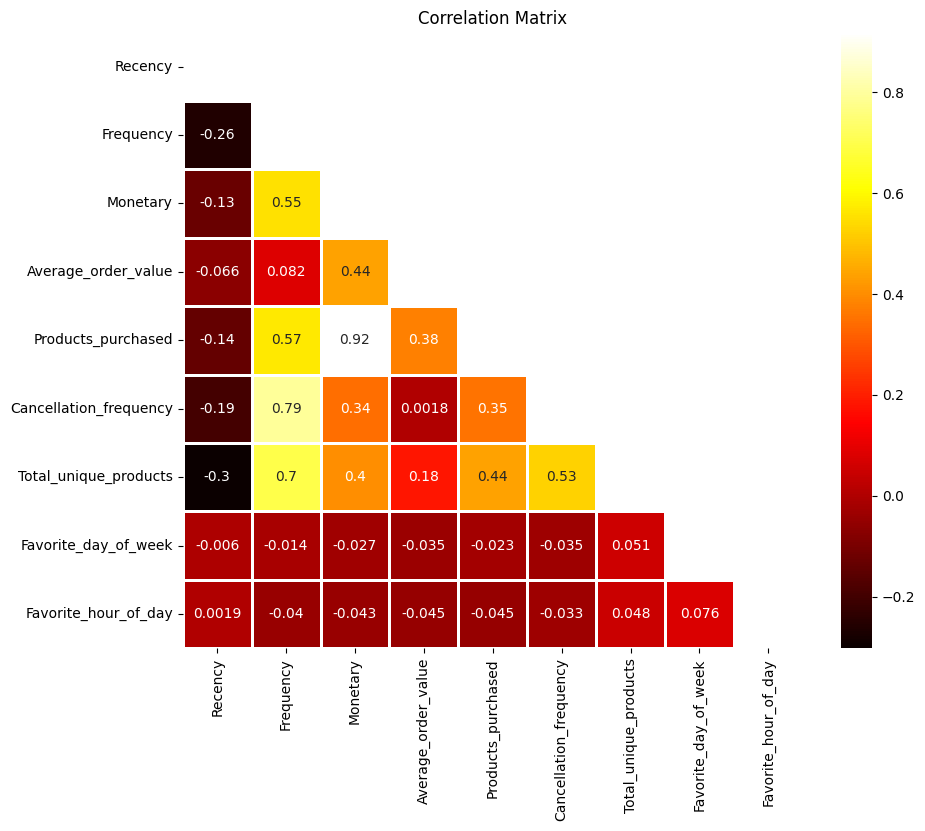

In [203]:
# We generate the heatmap

plt.figure(figsize=(10, 8))

sns.heatmap(correlation_matrix, annot = True, cmap = "hot", linewidths = 2, mask = mask)

plt.title("Correlation Matrix", fontsize = 12)

# Display the heatmap

plt.show()

There isn't a strict treshold value that indicates multicollinearity or not. As it depends on the correlation coefficient, we know that 1 or -1 is the maximum value achievable for linear relationship between variables.

For this reason, we will consider 0,7 a coefficient where there is multicollinearity between variables. Following this rule, we could appreciate that there is multicollinearity on the following pairs of variables:

- Total unique products & Frequency
- Cancellation Frequency & Frequency
- Products purchased & Monetary

There are methods like PCA (Principal Component Analysis), that might help reduce the dimensionality of those correlated variables. Since we only have 3 pairs of variables and two of them are pretty close to the value we determined for considering them multicollinear, we will not cover it in this analysis.

# **6) Normalize Features**

What we will cover in this part of the analysis, is normalizing the features to ensure they are on a similar scale, which is essential for clustering algorithms.

The process of scaling consists of transforming the features to have a mean of 0 and a standard deviation of 1.

To ensure a proper scaling, we need to consider which variables might not need to be scaled and why. Here we mention those variables:

- CustomerID: This variable is an identifier for each customer and does not give any valuable information for our cluster.
- Favorite day of the week: Since this variable is categorical, and it goes from a range of 1 to 7, it would not be necessary to scale it.

In [204]:
scaler = StandardScaler()

# Columns that we won't scalate

non_scalable_columns = ["CustomerID", "Favorite_day_of_week"]

# Columns that we will scale

scalable_columns = customer_features.columns.difference(non_scalable_columns)

# We create a copy of the dataframe to scale the values in it

customer_features_scaled = customer_features.copy()

# Apply the scaler

customer_features_scaled[scalable_columns] = scaler.fit_transform(customer_features_scaled[scalable_columns])

customer_features_scaled

,CustomerID,Recency,Frequency,Monetary,Average_order_value,Products_purchased,Cancellation_frequency,Total_unique_products,Favorite_day_of_week,Favorite_hour_of_day
0,12346.0,2.310709,-0.329690,-0.229262,-0.820201,-0.239344,0.114243,-0.705098,1,-1.076454
1,12347.0,-0.888535,0.220845,0.292206,0.753996,0.287155,-0.394774,0.489897,1,0.653965
2,12348.0,-0.165486,-0.109476,-0.055370,0.098447,0.260166,-0.394774,-0.470785,3,2.816988
3,12349.0,-0.730059,-0.439797,-0.052913,2.906318,-0.104399,-0.394774,0.126713,0,-1.509058
4,12350.0,2.162137,-0.439797,-0.193643,-0.067508,-0.197361,-0.394774,-0.529363,2,1.519174
...,...,...,...,...,...,...,...,...,...,...
4357,18280.0,1.835280,-0.439797,-0.207412,-0.358460,-0.229705,-0.394774,-0.599657,0,-1.509058
4358,18281.0,0.874516,-0.439797,-0.219484,-0.613568,-0.227777,-0.394774,-0.634804,6,-1.076454
4359,18282.0,-0.839011,-0.219583,-0.207896,-0.669696,-0.218352,0.114243,-0.576226,4,0.221360
4360,18283.0,-0.878630,1.211809,0.017507,-0.494288,0.050895,-0.394774,2.352684,3,0.653965


# **7) K-means Clustering**

**Definition**

K-Means is an unsupervised machine learning technique which segregates data into a predetermined number of clusters (K) by minimizing the total distance within each cluster, commonly referred to as inertia or within-cluster sum-of-squares (WCSS).

This algorithm sequentially assigns each data point to the nearest centroid and then adjusts the centroids by computing the mean of the points assigned to them. This cycle continues until either convergence is achieved or a predefined stopping criterion is met.

**Limitations**

However, despite its popularity, K-Means has some limitations.
- It requires the user to specify the number of clusters beforehand, which might not always be straightforward or optimal.
- It is sensitive to the initial placement of centroids, which can lead to different clusterings for different initializations. - K-Means assumes that clusters are spherical and of equal size, which might not reflect the true distribution of the data, resulting in suboptimal clustering performance, especially for non-linearly separable data.
- K-Means can be computationally expensive, especially for large datasets, as it requires calculating distances between all data points and centroids in each iteration.

## **7.1) Optimal number of clusters**

**ELBOW METHOD**

Before applying the model to our scaled dataframe, we need one of the most important steps in this process. It consists of defining the optimal number of clusters in which we're going to group the different customer profiles.

For doing so, we will use the Elbow method. This method involves iterating through the data, generating clusters for various values of k. Its name is given by the shape of its graph which at the point where it decreases significantly (reminds an elbow), it indicates where increasing k (number of clusters) stops being optimal.

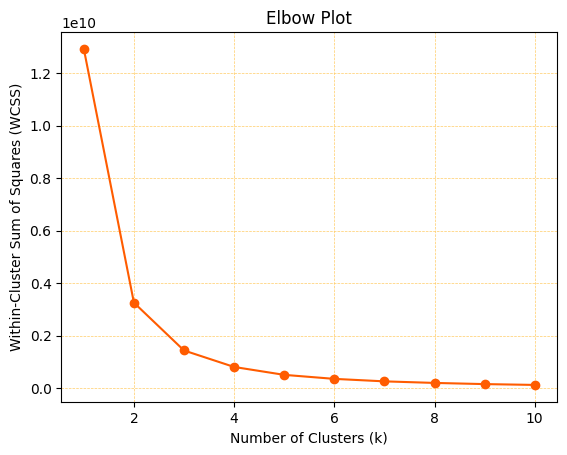

In [205]:
wcss = []

k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters = k, init = "k-means++", max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(customer_features_scaled)
    wcss.append(kmeans.inertia_)

grid_color = (1.0, 0.8, 0.4)
plt.grid(color = grid_color, linestyle = "--", linewidth = 0.5)
plt.plot(k_values, wcss, marker = "o", color = plt.cm.hot(0.5))
plt.title("Elbow Plot")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Within-Cluster Sum of Squares (WCSS)")
plt.show()

As we could see, there is a huge decrease from k = 1 to k = 2. Despite that, we can consider the optimal value to be between 1 and 3 since the graph keeps decreasing significantly up to that point. For this reason, we will take 2 as the optimal value for k since it's the point where the graph starts to be almost horizontal with the x axis.

## **7.2) Evaluate the quality of clusters**

**SILHOUETTE METHOD**

For evaluating the most optimal number of clusters, there's a method called Silhouette Method. It's used to evaluate the quality of clusters in a clustering algorithm, such as K-means. It provides a measure of how well-separated the clusters are and how similar the data points are within their own clusters compared to neighboring clusters.

In order to determine which is the most optimal number of clusters, there's the Silhouette Score which quantifies how similar an object is to its own cluster (cohesion) compared to other clusters (separation). Its value ranges from -1 to 1, where:

- A score close to +1 indicates that the data point is well-clustered, with data points in the same cluster being close to each other and far from data points in other clusters.
- A score close to 0 indicates that the data point is close to the decision boundary between two clusters.
- A score close to -1 indicates that the data point may have been assigned to the wrong cluster. 

In [206]:
# We need to set a new range for k_values starting from 2 or we will get an error

k_values = range(2, 11)

# We define a list to store all the scores for each k in the range defined above

silhouette_scores_list = []

for k in k_values:
    kmeans = KMeans(n_clusters = k, random_state = 0, n_init = 10)
    kmeans.fit(customer_features_scaled)
    
    cluster_labels = kmeans.labels_
    
    # We store the score and the avg in these 2 variables
    
    silhouette_avg = silhouette_score(customer_features_scaled, cluster_labels)
    silhouette_scores_list.append(silhouette_avg)

# Print silhouette scores for each k

for k, score in zip(k_values, silhouette_scores_list):
    print(f"Silhouette score for k = {k} : {score}")

Silhouette score for k = 2 : 0.624118714428629
Silhouette score for k = 3 : 0.5901868927415682
Silhouette score for k = 4 : 0.570980721086979
Silhouette score for k = 5 : 0.5658122044170384
Silhouette score for k = 6 : 0.5554709804682455
Silhouette score for k = 7 : 0.5499983920752535
Silhouette score for k = 8 : 0.5422243633913592
Silhouette score for k = 9 : 0.5438569189710352
Silhouette score for k = 10 : 0.54546651490681


## **7.3) Visualizations of silhouettes**

The silhouette plot serves as a diagnostic tool to evaluate the quality of clustering algorithms, particularly in assessing the appropriateness of the number of clusters chosen. It provides a visual representation of the clustering performance for each data point.

- **Line Length:** Each data point is represented by a vertical line, the length of which reflects the degree of fit of the point to its assigned cluster. Longer lines indicate a better match within the cluster, while shorter lines suggest potential misclassification.

- **Position:** The position of the line relative to the clusters indicates the cluster to which the data point has been assigned.

- **Line Width:** The width of the silhouette around each point signifies the density of the cluster. Wider silhouettes denote denser clusters with points closer together.

- **Average Silhouette Score:** The average silhouette score, computed across all data points, offers an overall measure of clustering quality. A higher average silhouette score suggests well-separated clusters with instances more similar to their own cluster than to others.

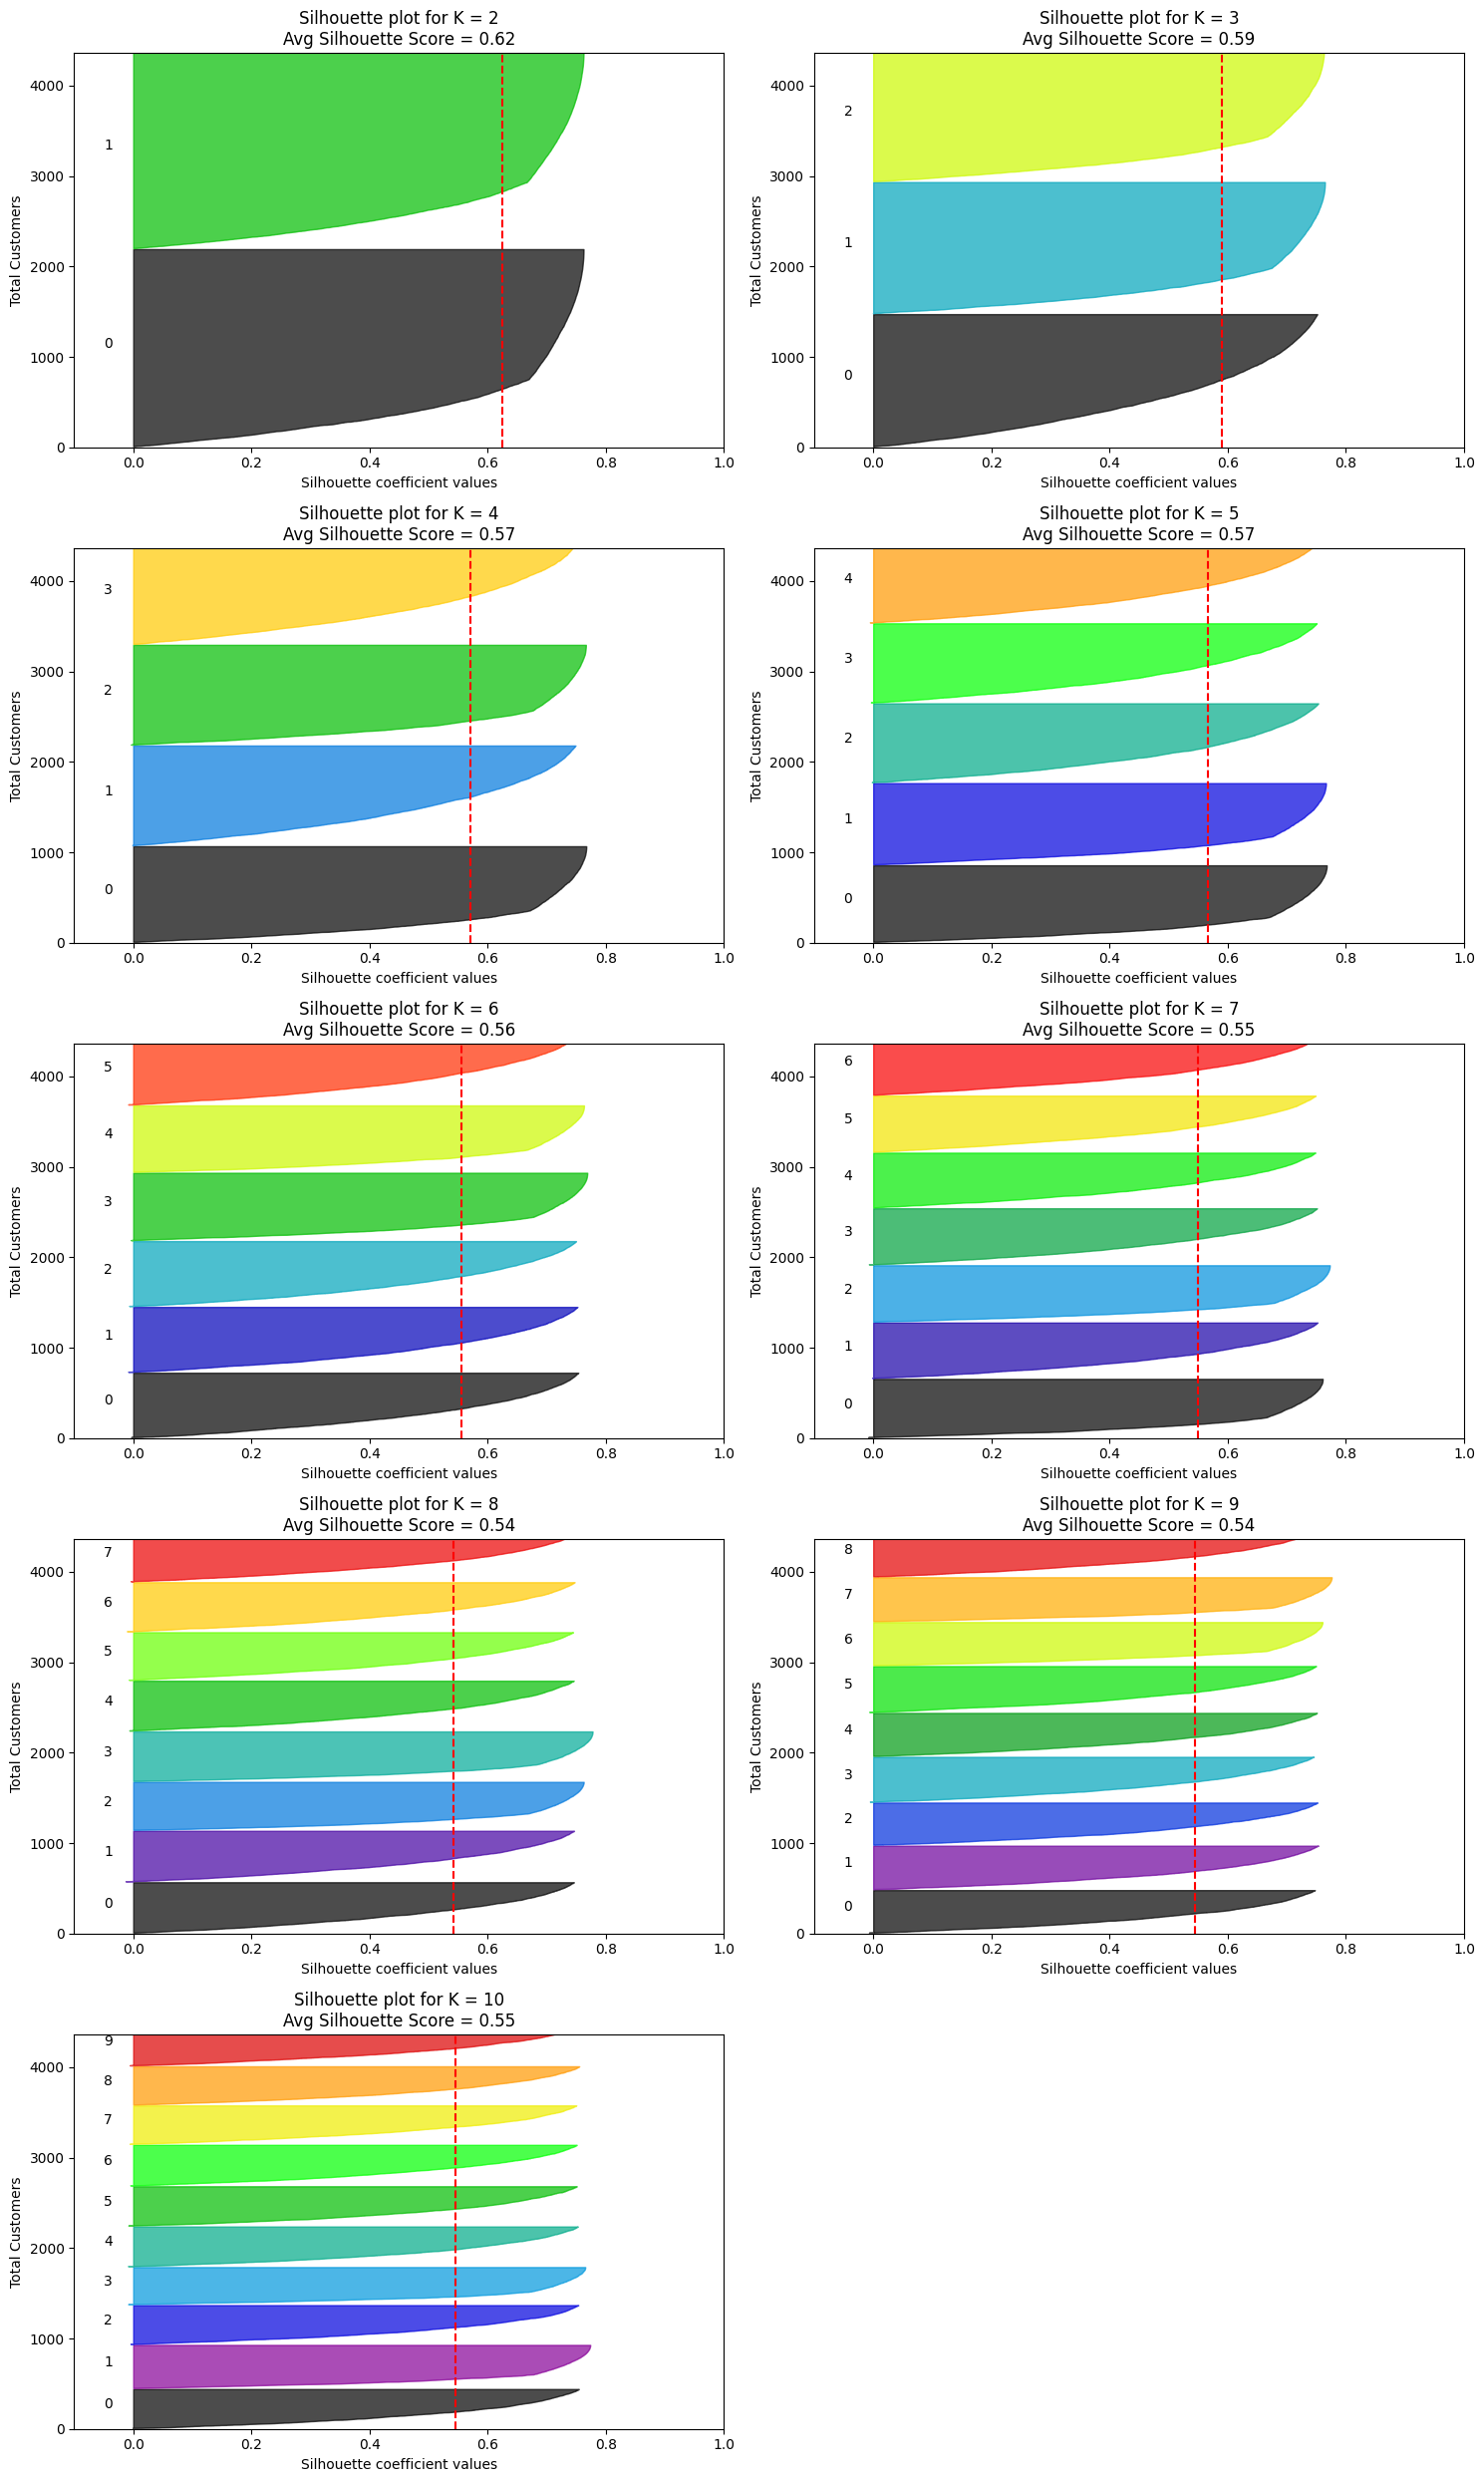

In [207]:
# Calculate the number of rows needed for the subplot grid
num_rows = len(k_values) // 2 + (len(k_values) % 2 > 0)

# Create a subplot grid with num_rows rows and 2 columns
fig, ax = plt.subplots(num_rows, 2, figsize=(15, 5*num_rows))

for i, k in enumerate(k_values):
    row = i // 2
    col = i % 2
    
    # Fit K-means clustering algorithm
    kmeans = KMeans(n_clusters=k, random_state=0, n_init = 10)
    cluster_labels = kmeans.fit_predict(customer_features_scaled)
    
    # Calculate silhouette score
    silhouette_avg = silhouette_score(customer_features_scaled, cluster_labels)
    
    # Calculate silhouette scores for each data point
    sample_silhouette_values = silhouette_samples(customer_features_scaled, cluster_labels)
    
    # Create a subplot for each value of k
    ax[row, col].set_xlim([-0.1, 1])
    ax[row, col].set_ylim([0, len(customer_features_scaled)])  # Set y-axis limits to total number of entries
    
    y_lower = 10
    
    for j in range(k):
        # Aggregate silhouette scores for samples in cluster j
        cluster_silhouette_values = sample_silhouette_values[cluster_labels == j]
        cluster_silhouette_values.sort()
        
        size_cluster_j = cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_j
        
        color = plt.cm.nipy_spectral(float(j) / k)
        ax[row, col].fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
        
        # Label silhouette plots with their cluster numbers at the middle
        ax[row, col].text(-0.05, y_lower + 0.5 * size_cluster_j, str(j))
        
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the gap between clusters
    
    ax[row, col].set_title(f'Silhouette plot for K = {k}\nAvg Silhouette Score = {silhouette_avg:.2f}')
    ax[row, col].set_xlabel('Silhouette coefficient values')
    ax[row, col].set_ylabel('Total Customers')
    
    # The vertical line for average silhouette score of all the values
    ax[row, col].axvline(x=silhouette_avg, color='red', linestyle='--')
    
    ax[row, col].set_yticks(np.arange(0, len(customer_features_scaled), step=1000))  # Set y-axis ticks at intervals of 1000 entries
    
# Hide any unused subplots
for i in range(len(k_values), num_rows*2):
    ax[num_rows-1, i % 2].axis('off')

plt.tight_layout()
plt.show()

# **8) Apply clustering algorithm**

Once we determined the optimal number of clusters, we can proceed to assign to each customer its cluster group.

For doing so, we're going to apply the K-means clustering algorithm to segment them based on their purchasing behaviours and other characteristics analyzed in the dataframe.

In [208]:
# We define the numer of clusters

n_clusters = 2

# Initialize the k-means algorithm

kmeans = KMeans(n_clusters = n_clusters, random_state = 42)

# We fit the model to our scaled data

kmeans.fit(customer_features_scaled)

# Prediction of the cluster labels for each customer

cluster_labels = kmeans.predict(customer_features_scaled)

# We add the cluster labels to the scaled dataframe

customer_features_scaled["Cluster"] = cluster_labels

C:\Users\Fran\Documents\Ironhack\Course\Project Final\final_project\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [209]:
customer_features_scaled

,CustomerID,Recency,Frequency,Monetary,Average_order_value,Products_purchased,Cancellation_frequency,Total_unique_products,Favorite_day_of_week,Favorite_hour_of_day,Cluster
0,12346.0,2.310709,-0.329690,-0.229262,-0.820201,-0.239344,0.114243,-0.705098,1,-1.076454,0
1,12347.0,-0.888535,0.220845,0.292206,0.753996,0.287155,-0.394774,0.489897,1,0.653965,0
2,12348.0,-0.165486,-0.109476,-0.055370,0.098447,0.260166,-0.394774,-0.470785,3,2.816988,0
3,12349.0,-0.730059,-0.439797,-0.052913,2.906318,-0.104399,-0.394774,0.126713,0,-1.509058,0
4,12350.0,2.162137,-0.439797,-0.193643,-0.067508,-0.197361,-0.394774,-0.529363,2,1.519174,0
...,...,...,...,...,...,...,...,...,...,...,...
4357,18280.0,1.835280,-0.439797,-0.207412,-0.358460,-0.229705,-0.394774,-0.599657,0,-1.509058,1
4358,18281.0,0.874516,-0.439797,-0.219484,-0.613568,-0.227777,-0.394774,-0.634804,6,-1.076454,1
4359,18282.0,-0.839011,-0.219583,-0.207896,-0.669696,-0.218352,0.114243,-0.576226,4,0.221360,1
4360,18283.0,-0.878630,1.211809,0.017507,-0.494288,0.050895,-0.394774,2.352684,3,0.653965,1


# **9) Evaluation metrics**

Right before definining the recommendation system for each customer depending on the cluster they are assigned, we will calculate some metrics in order to evaluate the quality of our model.

We have seen already a couple metrics that give us an insight about our model. These 2 metrics are the following ones:

- **Silhouette score:** A measure to evaluate the separation distance between the clusters. Higher values indicate better cluster separation. It ranges from -1 to 1. In our case we got a 0,62 score for 2 clusters which is a pretty good value.
- **WCSS (Within-cluster sum of squares):** It measures the compactness of clusters. The lower the value the more compact and the better clustering. In our elbow plot we could see it has a value a bit higher than 0,3.

Aside these 2 already calculated metrics, we're going to check the two other most common ones that are:

- **DBI (Davies Bouldin Index):** It measures the average similarity ratio of each cluster with the cluster that is most similar to it. The lower the values the better the cluster.
- **Calinski-Harabasz Index (Variance Ratio Criterion):** It's the ratio of the total dispersion between clusters to the total dispersion within clusters. The higher the values the better the cluster.

In [210]:
# Calculate the DBI

dbi = davies_bouldin_score(customer_features_scaled, cluster_labels)

print(f"Davies-Bouldin Index: {dbi}")

# Calculate Calinski-Harabasz Index

chi = calinski_harabasz_score(customer_features_scaled, cluster_labels)

print(f"Calinski-Harabasz Index: {chi}")

Davies-Bouldin Index: 0.5032813641944209
Calinski-Harabasz Index: 12932.499108032709


# **10) Recommendation System**

As the final part of our project, we will create a new dataframe with the recommended products for each customer. This system will take into account the cluster of each customer in order to suggest 3 specific products. An important detail to take into account is suggesting a product that customer has not already bought, in order to be a precise recommendation.

## **10.1) Best-seller products for each cluster**

In [211]:
# We create a variable to store only the customer_id and the cluster assigned to it

customer_cluster = customer_features_scaled[["CustomerID", "Cluster"]]

# We add the cluster column to our original dataframe

df = pd.merge(df, customer_cluster, on = "CustomerID")

df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Completion_status,InvoiceDay,Total_spent,Day_of_week,Hour,Cluster
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,True,2010-12-01,15.30,2,8,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,True,2010-12-01,20.34,2,8,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,True,2010-12-01,22.00,2,8,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,True,2010-12-01,20.34,2,8,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,True,2010-12-01,20.34,2,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399651,581578,22993,SET OF 4 PANTRY JELLY MOULDS,12,2011-12-09 12:16:00,1.25,12713.0,Germany,True,2011-12-09,15.00,4,12,0
399652,581578,22907,PACK OF 20 NAPKINS PANTRY DESIGN,12,2011-12-09 12:16:00,0.85,12713.0,Germany,True,2011-12-09,10.20,4,12,0
399653,581578,22908,PACK OF 20 NAPKINS RED APPLES,12,2011-12-09 12:16:00,0.85,12713.0,Germany,True,2011-12-09,10.20,4,12,0
399654,581578,23215,JINGLE BELL HEART ANTIQUE SILVER,12,2011-12-09 12:16:00,2.08,12713.0,Germany,True,2011-12-09,24.96,4,12,0


In [212]:
# We create a variable to store the best-seller products for each cluster

best_seller_products = df.groupby(["Cluster", "StockCode", "Description"])["Quantity"].sum().reset_index()

In [213]:
# We sort the best seller products for each cluster

best_seller_products = best_seller_products.sort_values(by = ["Cluster", "Quantity"], ascending = [True, False])

# We take the top 10 for each cluster

top_10_products_cluster = best_seller_products.groupby("Cluster").head(10)

In [214]:
top_10_products_cluster

,Cluster,StockCode,Description,Quantity
345,0,21212,PACK OF 72 RETROSPOT CAKE CASES,23563
2565,0,84879,ASSORTED COLOUR BIRD ORNAMENT,22920
997,0,22197,SMALL POPCORN HOLDER,22702
1827,0,23084,RABBIT NIGHT LIGHT,22129
2468,0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,21134
3260,0,85099B,JUMBO BAG RED RETROSPOT,21008
821,0,21977,PACK OF 60 PINK PAISLEY CAKE CASES,15117
1260,0,22492,MINI PAINT SET VINTAGE,14249
3266,0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,13967
2593,0,84991,60 TEATIME FAIRY CAKE CASES,12374


## **10.2) Products purchased by each customer in each cluster**

In [215]:
# We store in a new variable a record of the products purchased by each customer and each cluster

customer_purchases = df.groupby(["CustomerID", "Cluster", "StockCode"])["Quantity"].sum().reset_index()

## **10.3) Recommendations for each cluster & products already purchased**

In [216]:
# First we add the cluster column to our customer_features dataframe

customer_features = pd.merge(customer_features, customer_cluster, on = "CustomerID")

customer_features

,CustomerID,Recency,Frequency,Monetary,Average_order_value,Products_purchased,Cancellation_frequency,Total_unique_products,Favorite_day_of_week,Favorite_hour_of_day,Cluster
0,12346.0,325,2,0.00,0.000000,0,1.0,1,1,10,0
1,12347.0,2,7,4310.00,615.714286,2458,0.0,103,1,14,0
2,12348.0,75,4,1437.24,359.310000,2332,0.0,21,3,19,0
3,12349.0,18,1,1457.55,1457.550000,630,0.0,72,0,9,0
4,12350.0,310,1,294.40,294.400000,196,0.0,16,2,16,0
...,...,...,...,...,...,...,...,...,...,...,...
4357,18280.0,277,1,180.60,180.600000,45,0.0,10,0,9,1
4358,18281.0,180,1,80.82,80.820000,54,0.0,7,6,10,1
4359,18282.0,7,3,176.60,58.866667,98,1.0,12,4,13,1
4360,18283.0,3,16,2039.58,127.473750,1355,0.0,262,3,14,1


In [217]:
# We generate recommendations for each customer taking into account already purchased products

recommendations = []

for Cluster in top_10_products_cluster["Cluster"].unique():
    top_products = top_10_products_cluster[top_10_products_cluster["Cluster"] == Cluster]
    customers_in_cluster = customer_features[customer_features["Cluster"] == Cluster]["CustomerID"]
    
    for customer in customers_in_cluster:
        # Identify products already purchased by the customer
        customer_purchased_products = customer_purchases[(customer_purchases["CustomerID"] == customer) & 
                                                         (customer_purchases["Cluster"] == Cluster)]["StockCode"].tolist()
        
        # Find top 3 products in the best-selling list that the customer hasn't purchased yet
        top_products_not_purchased = top_products[~top_products["StockCode"].isin(customer_purchased_products)]
        top_3_products_not_purchased = top_products_not_purchased.head(3)
        
        # Append the recommendations to the list
        recommendations.append([customer, Cluster] + top_3_products_not_purchased[["StockCode", "Description"]].values.flatten().tolist())

## **10.4) Dataframe with the recommendations for each customer**

Once the recommendations list is created, we can proceed to transform it into a dataframe.

In [218]:
recommendations_df = pd.DataFrame(recommendations, columns=["CustomerID", "Cluster", "Rec1_StockCode", "Rec1_Description", \
                                                 "Rec2_StockCode", "Rec2_Description", "Rec3_StockCode", "Rec3_Description"])

recommendations_df

,CustomerID,Cluster,Rec1_StockCode,Rec1_Description,Rec2_StockCode,Rec2_Description,Rec3_StockCode,Rec3_Description
0,12346.0,0,21212,PACK OF 72 RETROSPOT CAKE CASES,84879,ASSORTED COLOUR BIRD ORNAMENT,22197,SMALL POPCORN HOLDER
1,12347.0,0,21212,PACK OF 72 RETROSPOT CAKE CASES,84879,ASSORTED COLOUR BIRD ORNAMENT,22197,SMALL POPCORN HOLDER
2,12348.0,0,21212,PACK OF 72 RETROSPOT CAKE CASES,84879,ASSORTED COLOUR BIRD ORNAMENT,22197,SMALL POPCORN HOLDER
3,12349.0,0,21212,PACK OF 72 RETROSPOT CAKE CASES,84879,ASSORTED COLOUR BIRD ORNAMENT,22197,SMALL POPCORN HOLDER
4,12350.0,0,21212,PACK OF 72 RETROSPOT CAKE CASES,84879,ASSORTED COLOUR BIRD ORNAMENT,22197,SMALL POPCORN HOLDER
...,...,...,...,...,...,...,...,...
4357,18280.0,1,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,22197,SMALL POPCORN HOLDER,85099B,JUMBO BAG RED RETROSPOT
4358,18281.0,1,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,22197,SMALL POPCORN HOLDER,85099B,JUMBO BAG RED RETROSPOT
4359,18282.0,1,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,22197,SMALL POPCORN HOLDER,85099B,JUMBO BAG RED RETROSPOT
4360,18283.0,1,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,17003,BROCADE RING PURSE,21915,RED HARMONICA IN BOX


# **11) Exports**

In [220]:
# We specify the path where we want to store the dataframes we will use for visualizations with Tableau

file_path_df = "../data/clean/df.csv"

file_path_customer_features = "../data/clean/customer_features.csv"

file_path_recommendations = "../data/clean/recommendations.csv"


In [147]:
# We export the dataframes to CSV at the defined path

df.to_csv(file_path_df, index=False)

customer_features.to_csv(file_path_customer_features, index=False)

recommendations_df.to_csv(file_path_recommendations, index=False)